### Cab-Driver Agent

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt



In [3]:
%pwd


'/content'

In [4]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/')
%cd /content/gdrive/MyDrive/Colab Notebooks
%pwd
# Import the environment
from Env import CabDriver

/content/gdrive/MyDrive/Colab Notebooks


#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
time_matrix = np.load("/content/gdrive/MyDrive/Colab Notebooks/TM.npy")
time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001      
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.0009
        self.epsilon_min = 0.00000001
        self.batch_size = 256        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch2([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(50,activation='relu',input_dim= self.state_size, kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episodes):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episodes)
        z = np.random.random()
        actions_index, agent_actions = env.requests(state) # get all possible actions for the state 
        #print("get_action : actions_index,",actions_index) 
        #print("get_action : state,",state)  
        if z > epsilon:
            encoded_state = np.array(env.state_encod_arch2(state)).reshape(1, 36)
            q_pred_states = self.model.predict(encoded_state)
            #print("q_pred_states from model,", q_pred_states)
            q_state_pos_actions = {q_pred_states[0][i]  for i in actions_index}
            #print("q_state_pos_actions from possible action spaces,", q_state_pos_actions)
            action_index = actions_index[np.argmax(q_state_pos_actions)]   #Exploitation: this gets the action corresponding to max q-value of current state
        else:       
            #print("epsilon greedy agent actions,", agent_actions)
            action_index = random.choice(actions_index)   #Exploration: randomly choosing and action
        
        return action_index      
        
    

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size))# write here
            actions_index, reward = [], []
            
            for i in range(self.batch_size):
                state, action_index, reward, next_state = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                           
                actions_index.append(action_index)
                rewards.append(reward)
                # Write your code from here
                # 1. Predict the target from earlier model
                # 2. Get the target for the Q-network                
                #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
                update_input[i] = env.state_encod_arch2(state)
                update_output[i] = env.state_encod_arch2(next_state)              
                
            # 4. Fit your model and track the loss values
            q_vals = self.model.predict(update_output) ## (batchsize,len(action_space))
            target = self.model.predict(update_input)

            #print("actions from batch,", actions_index)
            #print("rewards from batch,", rewards)
            #print("q_vals from batch and model,", q_vals)
            #print("target from batch and model,", target)
            
            for i in range(self.batch_size):
                  target[i][actions_index[i]] = rewards[i] + self.discount_factor*max(q_vals[i])

            self.model.fit(update_input, target)


    def save(self, name):
        self.model.save_weights(name)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index 2 that we are tracking.
        self.states_tracked.append(q_value[0][2])

In [8]:
Episodes = 5000

### DQN block

In [9]:
import time
start_time = time.time()
rewards = []
episodes = []
env = CabDriver()
agent = DQNAgent(36, len(env.action_space))
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver() # initialise the state
    terminal_state = False
    # initialising the current state
    curr_state = env.state_init
    total_time_driven = 0
    
    total_reward_per_episode = 0
    count = 0
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        count+=1
        action_index = agent.get_action(curr_state, episode)
        #print("curr_state :", curr_state)
        reward = env.reward_func(curr_state, env.action_space[action_index], time_matrix)
        next_state, total_time_driven = env.next_state_func(curr_state, env.action_space[action_index], time_matrix, total_time_driven)
        agent.append_sample(curr_state, action_index, reward, next_state)
        if count%20 == 0:
            agent.train_model()
        total_reward_per_episode = total_reward_per_episode + reward

        if total_time_driven >= 720: # set the terminal_state true
          terminal_state = True
        else:
          curr_state = next_state
          
        
    # Total rewards per episode
    rewards.append(total_reward_per_episode)
    episodes.append(episode)
    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("Episode ran {0}, reward is {1}, memory_length is {2}, total_time is {3}".format(episode+1,
                                                                         total_reward_per_episode,
                                                                         len(agent.memory),
                                                                         total_time_driven))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 100 == 0):
        agent.save_tracking_states()
    if ((episode + 1) % 1000 == 0):
        print('Saving in the episode ', episode+1)
        agent.save(name="model_weights.h5")

elapsed_time = time.time() - start_time
print('Total Execution time: ', elapsed_time)       
agent.save(name="model_weights.h5")  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 2ms/step - loss: 15.9614
Episode ran 1900, reward is -42.0, memory_length is 2000, total_time is 725.0
8/8 [==============================] - 0s 2ms/step - loss: 15.9347
Episode ran 2000, reward is 168.0, memory_length is 2000, total_time is 738.0
Saving in the episode  2000
8/8 [==============================] - 0s 2ms/step - loss: 16.0366
Episode ran 2100, reward is 43.0, memory_length is 2000, total_time is 724.0
8/8 [==============================] - 0s 2ms/step - loss: 15.8322
Episode ran 2200, reward is 85.0, memory_length is 2000, total_time is 725.0
8/8 [==============================] - 0s 2ms/step - loss: 15.8896
Episode ran 2300, reward is -23.0, memory_length is 2000, total_time is 729.0
8/8 [==============================] - 0s 3ms/step - loss: 16.0731
Episode ran 2400, reward is 52.0, memory_length is 2000, total_time is 738.0
8/8 [==============================] - 0s 2ms/step - l

### Tracking Convergence

In [10]:
len(agent.states_tracked)



50

In [11]:
agent.states_tracked

[0.9011878,
 1.6307527,
 2.5856333,
 6.4787354,
 12.211181,
 16.349337,
 18.486607,
 19.193964,
 22.755442,
 22.186226,
 23.228577,
 23.139114,
 24.387094,
 24.97376,
 25.901718,
 26.368767,
 25.539312,
 26.572714,
 23.695728,
 24.48528,
 23.479486,
 23.481249,
 22.607635,
 25.005856,
 23.712763,
 24.459154,
 24.846235,
 24.007284,
 23.159248,
 22.810083,
 23.658428,
 24.369862,
 23.438555,
 21.96462,
 22.42927,
 23.560999,
 23.50497,
 24.659105,
 25.695826,
 25.61457,
 27.040018,
 25.182844,
 25.347029,
 25.401348,
 23.476166,
 23.105991,
 23.041746,
 21.99833,
 24.281868,
 23.09667]

**Plot the Q-Value convergence for state action pairs**

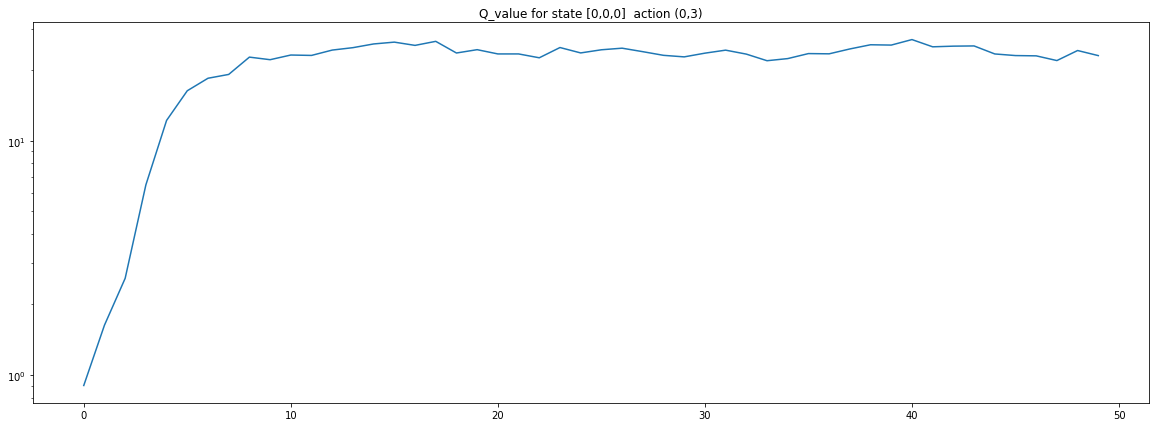

In [12]:
plt.figure(0, figsize=(20,7))
plt.title('Q_value for state [0,0,0]  action (0,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

**Track rewards per episode**

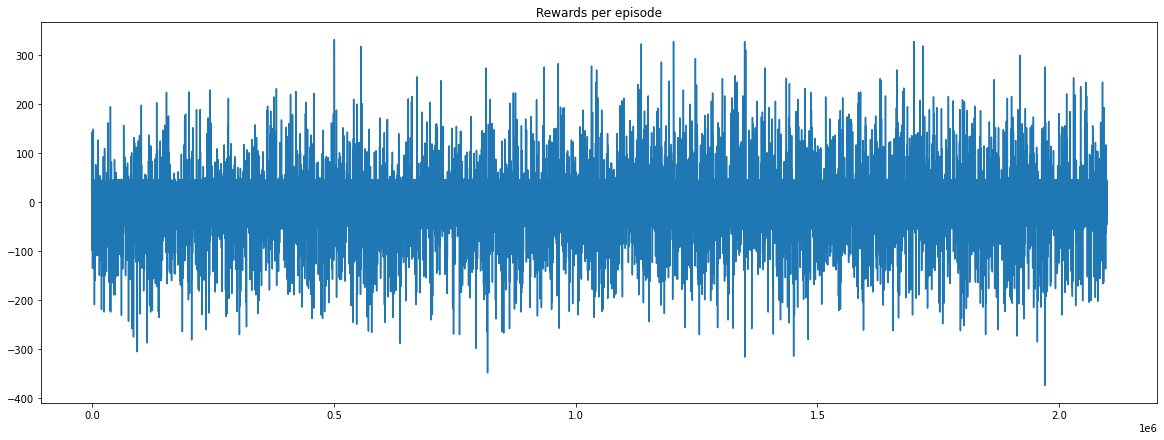

In [13]:
plt.figure(0, figsize=(20,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards)))
plt.plot(xaxis,np.asarray(rewards))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0.00000001 + (1 - 0.00000001) * np.exp(-0.0009*i))

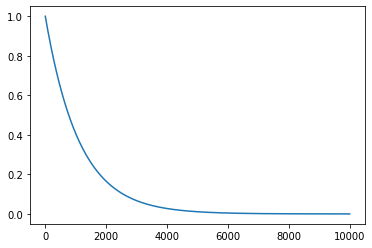

In [15]:
plt.plot(time, epsilon)
plt.show()